### Setup

In [5]:
!./venv/bin/pip install kaggle scikit-learn numpy matplotlib seaborn reparo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 48.9 MB/s eta 0:00:001m53.7 MB/s eta 0:00:01

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
!kaggle datasets download mansoordaku/ckdisease

Dataset URL: https://www.kaggle.com/datasets/mansoordaku/ckdisease
License(s): unknown
  0%|                                               | 0.00/9.51k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 9.51k/9.51k [00:00<00:00, 8.31MB/s]


In [4]:
!unzip ckdisease.zip

Archive:  ckdisease.zip
  inflating: kidney_disease.csv      


### Imports

In [278]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from reparo import CDI, FRNNI, HotDeckImputation, KNNImputer, PMM, SICE, MICE
import warnings

### Dataset

In [7]:
ck_df = pd.read_csv("./kidney_disease.csv")

In [15]:
ck_df.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [8]:
ck_df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


#### Percentage of Missing Values

In [27]:
ck_df.isna().sum().sort_values(ascending=False) / ck_df.last_valid_index()

rbc               0.380952
rc                0.325815
wc                0.263158
pot               0.220551
sod               0.218045
pcv               0.175439
pc                0.162907
hemo              0.130326
su                0.122807
sg                0.117794
al                0.115288
bgr               0.110276
bu                0.047619
sc                0.042607
bp                0.030075
age               0.022556
ba                0.010025
pcc               0.010025
htn               0.005013
dm                0.005013
cad               0.005013
ane               0.002506
appet             0.002506
pe                0.002506
id                0.000000
classification    0.000000
dtype: float64

Bar Plot of Number of Missing Values in each Column

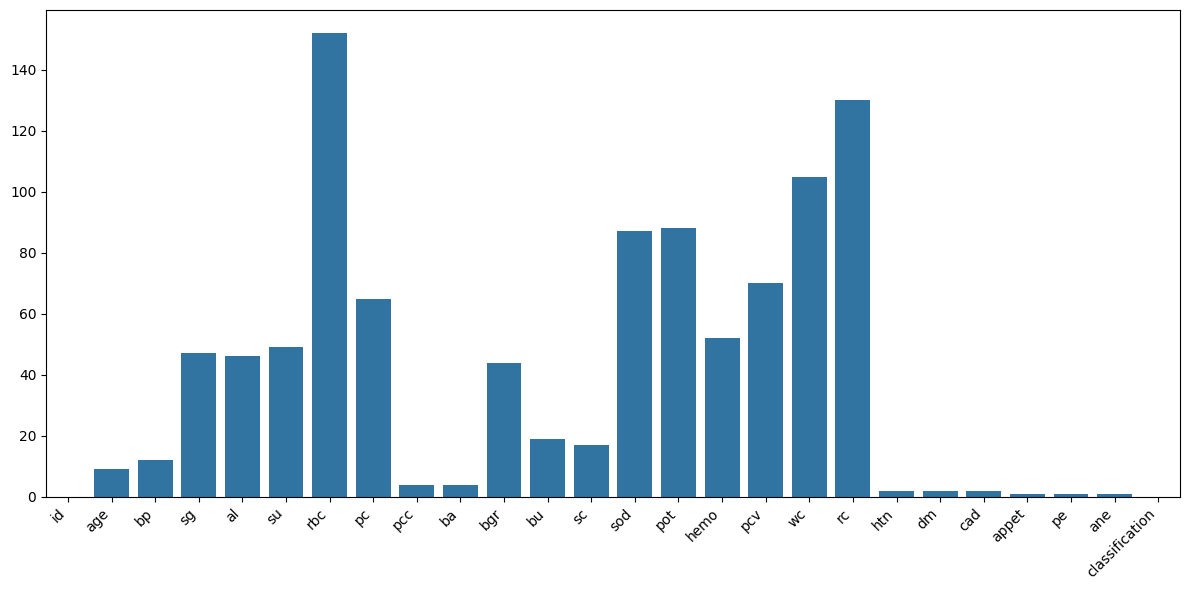

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ck_df.isna().sum())
plt.xticks(rotation=45, ha='right')  
plt.tight_layout() 

Print Categorical Columns Vales

In [42]:
cat_cols = ["rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane", "classification"]

for col in cat_cols:
    print(ck_df[col].value_counts())


rbc
normal      201
abnormal     47
Name: count, dtype: int64
pc
normal      259
abnormal     76
Name: count, dtype: int64
pcc
notpresent    354
present        42
Name: count, dtype: int64
ba
notpresent    374
present        22
Name: count, dtype: int64
htn
no     251
yes    147
Name: count, dtype: int64
dm
no       258
yes      134
\tno       3
\tyes      2
 yes       1
Name: count, dtype: int64
cad
no      362
yes      34
\tno      2
Name: count, dtype: int64
appet
good    317
poor     82
Name: count, dtype: int64
pe
no     323
yes     76
Name: count, dtype: int64
ane
no     339
yes     60
Name: count, dtype: int64
classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64


#### Convert Categorical

In [230]:
clean_df = ck_df.copy()

In [231]:
clean_df = clean_df.drop(columns=["id"])

In [232]:
yes_no_cols = ["htn", "dm", "cad", "pe", "ane"]

clean_df[yes_no_cols] = clean_df[yes_no_cols].apply(
    lambda x: x.str.strip().map({'yes': 1, 'no': 0})
)

In [233]:
clean_df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,1.0,1.0,0.0,good,0.0,0.0,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,0.0,0.0,0.0,good,0.0,0.0,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,0.0,1.0,0.0,poor,0.0,1.0,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,1.0,0.0,0.0,poor,1.0,1.0,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,0.0,0.0,0.0,good,0.0,0.0,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,0.0,0.0,0.0,good,0.0,0.0,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,0.0,0.0,0.0,good,0.0,0.0,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,0.0,0.0,0.0,good,0.0,0.0,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,0.0,0.0,0.0,good,0.0,0.0,notckd


In [234]:
normal_cols = ["rbc", "pc"]

clean_df[normal_cols] = clean_df[normal_cols].map(lambda x: 1 if x == "normal" else 0)

In [235]:
clean_df


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,0,1,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,1.0,1.0,0.0,good,0.0,0.0,ckd
1,7.0,50.0,1.020,4.0,0.0,0,1,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,0.0,0.0,0.0,good,0.0,0.0,ckd
2,62.0,80.0,1.010,2.0,3.0,1,1,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,0.0,1.0,0.0,poor,0.0,1.0,ckd
3,48.0,70.0,1.005,4.0,0.0,1,0,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,1.0,0.0,0.0,poor,1.0,1.0,ckd
4,51.0,80.0,1.010,2.0,0.0,1,1,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,0.0,0.0,0.0,good,0.0,0.0,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,notpresent,notpresent,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,0.0,0.0,0.0,good,0.0,0.0,notckd
396,42.0,70.0,1.025,0.0,0.0,1,1,notpresent,notpresent,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,0.0,0.0,0.0,good,0.0,0.0,notckd
397,12.0,80.0,1.020,0.0,0.0,1,1,notpresent,notpresent,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,0.0,0.0,0.0,good,0.0,0.0,notckd
398,17.0,60.0,1.025,0.0,0.0,1,1,notpresent,notpresent,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,0.0,0.0,0.0,good,0.0,0.0,notckd


In [236]:
present_cols = ["pc", "pcc", "ba"]

clean_df[present_cols] = clean_df[present_cols].map(lambda x: 1 if x == "present" else 0)

In [237]:
clean_df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,1.0,1.0,0.0,good,0.0,0.0,ckd
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,0.0,0.0,0.0,good,0.0,0.0,ckd
2,62.0,80.0,1.010,2.0,3.0,1,0,0,0,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,0.0,1.0,0.0,poor,0.0,1.0,ckd
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,1.0,0.0,0.0,poor,1.0,1.0,ckd
4,51.0,80.0,1.010,2.0,0.0,1,0,0,0,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,0.0,0.0,0.0,good,0.0,0.0,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,0,0,0,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,0.0,0.0,0.0,good,0.0,0.0,notckd
396,42.0,70.0,1.025,0.0,0.0,1,0,0,0,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,0.0,0.0,0.0,good,0.0,0.0,notckd
397,12.0,80.0,1.020,0.0,0.0,1,0,0,0,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,0.0,0.0,0.0,good,0.0,0.0,notckd
398,17.0,60.0,1.025,0.0,0.0,1,0,0,0,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,0.0,0.0,0.0,good,0.0,0.0,notckd


In [238]:
clean_df["appet"] = clean_df["appet"].str.strip().map({'good': 1, 'poor': 0})

In [239]:
clean_df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,ckd
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,ckd
2,62.0,80.0,1.010,2.0,3.0,1,0,0,0,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,ckd
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,ckd
4,51.0,80.0,1.010,2.0,0.0,1,0,0,0,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,0,0,0,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,0.0,0.0,0.0,1.0,0.0,0.0,notckd
396,42.0,70.0,1.025,0.0,0.0,1,0,0,0,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,0.0,0.0,0.0,1.0,0.0,0.0,notckd
397,12.0,80.0,1.020,0.0,0.0,1,0,0,0,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,0.0,0.0,0.0,1.0,0.0,0.0,notckd
398,17.0,60.0,1.025,0.0,0.0,1,0,0,0,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,0.0,0.0,0.0,1.0,0.0,0.0,notckd


In [240]:
clean_df["classification"] = clean_df["classification"].str.strip().map({'ckd': 1, 'notckd': 0})

In [241]:
clean_df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,1,0,0,0,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,1,0,0,0,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,0,0,0,140.0,49.0,0.5,150.0,4.9,15.7,47,6700,4.9,0.0,0.0,0.0,1.0,0.0,0.0,0
396,42.0,70.0,1.025,0.0,0.0,1,0,0,0,75.0,31.0,1.2,141.0,3.5,16.5,54,7800,6.2,0.0,0.0,0.0,1.0,0.0,0.0,0
397,12.0,80.0,1.020,0.0,0.0,1,0,0,0,100.0,26.0,0.6,137.0,4.4,15.8,49,6600,5.4,0.0,0.0,0.0,1.0,0.0,0.0,0
398,17.0,60.0,1.025,0.0,0.0,1,0,0,0,114.0,50.0,1.0,135.0,4.9,14.2,51,7200,5.9,0.0,0.0,0.0,1.0,0.0,0.0,0


Some numerical columns have `\t` as values or appended to int values. Remove them and convert to number

In [242]:
broken_num_cols = ["wc", "pcv", "rc"]

for col in broken_num_cols: 
    clean_df[col] = clean_df[col].replace("?", pd.NA).replace("\t?", pd.NA)

    clean_df[col] = clean_df[col].apply(
        lambda x: float(str(x).strip()) if pd.notna(x) else x
    )

    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')


In [243]:
clean_df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,1,0,0,0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,1,0,0,0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,0,0,0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9,0.0,0.0,0.0,1.0,0.0,0.0,0
396,42.0,70.0,1.025,0.0,0.0,1,0,0,0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2,0.0,0.0,0.0,1.0,0.0,0.0,0
397,12.0,80.0,1.020,0.0,0.0,1,0,0,0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4,0.0,0.0,0.0,1.0,0.0,0.0,0
398,17.0,60.0,1.025,0.0,0.0,1,0,0,0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9,0.0,0.0,0.0,1.0,0.0,0.0,0


Counting the values to check for anomalies

In [216]:
cat_cols = ["rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane", "classification"]

for col in clean_df.columns:
    print(clean_df[col].value_counts())


age
60.0    19
65.0    17
48.0    12
55.0    12
50.0    12
        ..
83.0     1
27.0     1
14.0     1
81.0     1
79.0     1
Name: count, Length: 76, dtype: int64
bp
80.0     116
70.0     112
60.0      71
90.0      53
100.0     25
50.0       5
110.0      3
140.0      1
180.0      1
120.0      1
Name: count, dtype: int64
sg
1.020    106
1.010     84
1.025     81
1.015     75
1.005      7
Name: count, dtype: int64
al
0.0    199
1.0     44
2.0     43
3.0     43
4.0     24
5.0      1
Name: count, dtype: int64
su
0.0    290
2.0     18
3.0     14
4.0     13
1.0     13
5.0      3
Name: count, dtype: int64
rbc
1    201
0    199
Name: count, dtype: int64
pc
0    400
Name: count, dtype: int64
pcc
0    358
1     42
Name: count, dtype: int64
ba
0    378
1     22
Name: count, dtype: int64
bgr
99.0     10
93.0      9
100.0     9
107.0     8
131.0     6
         ..
288.0     1
182.0     1
84.0      1
256.0     1
226.0     1
Name: count, Length: 146, dtype: int64
bu
46.0     15
25.0     13
19.0     11

In [244]:
clean_df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
count,391.000000,388.000000,353.000000,354.000000,351.000000,400.00000,400.0,400.000000,400.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000,398.000000,398.000000,398.000000,399.000000,399.000000,399.000000,400.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,0.50250,0.0,0.105000,0.055000,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435,0.369347,0.344221,0.085427,0.794486,0.190476,0.150376,0.625000
std,17.169714,13.683637,0.005717,1.352679,1.099191,0.50062,0.0,0.306937,0.228266,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323,0.483235,0.475712,0.279868,0.404584,0.393170,0.357888,0.484729
min,2.000000,50.000000,1.005000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,1.00000,0.0,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,1.00000,0.0,0.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,90.000000,180.000000,1.025000,5.000000,5.000000,1.00000,0.0,1.000000,1.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Correlation

<Axes: >

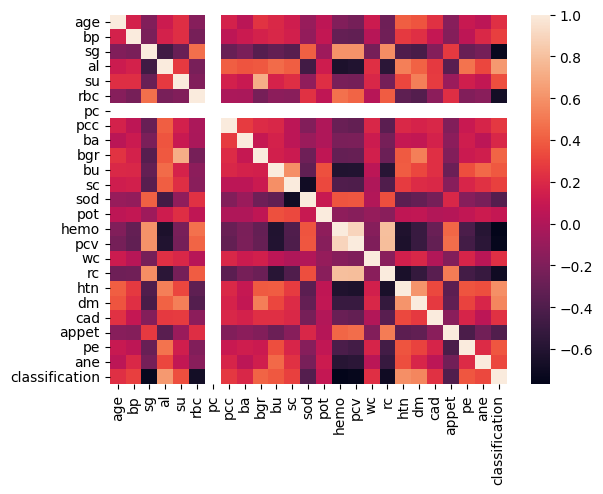

In [265]:
corr = clean_df.corr()
sns.heatmap(corr)

LogisticRegressor apparently cannot operate if a column has zero correlation to target. `pc` was causing the solution matrix to be singular, which is why it needs to be removed

In [266]:
clean_df = clean_df.drop(columns=['pc'])

### Splitting the Dataset

In [267]:
X = clean_df.drop(columns=["classification"])
y = clean_df["classification"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [289]:
X_train.shape, X_test.shape

((320, 23), (80, 23))

In [292]:
y_test.value_counts()

classification
1    52
0    28
Name: count, dtype: int64

### Data Imputing

In [33]:
imputers = [
    {"name": "Mean", "imputer": SimpleImputer(strategy="mean")},
    {"name": "Median", "imputer": SimpleImputer(strategy="median")},
    {"name": "Most Frequent", "imputer": SimpleImputer(strategy="most_frequent")},
    {"name": "Constant", "imputer": SimpleImputer(strategy="constant", fill_value=0)},
    {"name": "CDI", "imputer": CDI()},
    {"name": "FRNNI", "imputer": FRNNI()},
    {"name": "HotDeck", "imputer": HotDeckImputation()},
    {"name": "KNN", "imputer": KNNImputer()},
    {"name": "PMM", "imputer": PMM()},
    {"name": "SICE", "imputer": SICE()},
    {"name": "MICE", "imputer": MICE()}
]

In [281]:
models = [
    {"name": "Logistic Regression", "model": LogisticRegression(max_iter=1_000, random_state=42)},
    {"name": "Gaussian Naive Bayes", "model": GaussianNB()},
    {"name": "Decision Tree", "model": DecisionTreeClassifier(random_state=42)},
    {"name": "Random Forest", "model": RandomForestClassifier(random_state=42)}
]

For each combination of imputer and model, we construct a pipeline and get the score achieved from the combination of the two.

In [282]:
# Reparo library throws some errors because it uses older pandas syntax
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

acc_data = []

for imputer in imputers:
    for model in models:
        print(f"Training {model['name']} model with {imputer['name']} imputer...")
        pipeline = Pipeline([
            ('standard_scaler', StandardScaler()),
            (imputer["name"], imputer["imputer"]),
            (model["name"], model["model"])
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = f1_score(y_test, y_pred)

        acc_data.append([imputer["name"], model["name"], accuracy])

Training Logistic Regression model with Mean imputer...
Training Gaussian Naive Bayes model with Mean imputer...
Training Decision Tree model with Mean imputer...
Training Random Forest model with Mean imputer...
Training Logistic Regression model with Median imputer...
Training Gaussian Naive Bayes model with Median imputer...
Training Decision Tree model with Median imputer...
Training Random Forest model with Median imputer...
Training Logistic Regression model with Most Frequent imputer...
Training Gaussian Naive Bayes model with Most Frequent imputer...
Training Decision Tree model with Most Frequent imputer...
Training Random Forest model with Most Frequent imputer...
Training Logistic Regression model with Constant imputer...
Training Gaussian Naive Bayes model with Constant imputer...
Training Decision Tree model with Constant imputer...
Training Random Forest model with Constant imputer...
Training Logistic Regression model with CDI imputer...
Training Gaussian Naive Bayes mod

DataFrame with Imputer influence on Accuracy for each Model

In [295]:
acc_df = pd.DataFrame(acc_data, columns=["Imputation Algorithms", "Prediction Algorithms", "Accuracy"])
acc_df.sort_values(by=["Prediction Algorithms", "Accuracy"], ascending=False)

,Imputation Algorithms,Prediction Algorithms,Accuracy
3,Mean,Random Forest,1.000000
7,Median,Random Forest,1.000000
11,Most Frequent,Random Forest,1.000000
15,Constant,Random Forest,1.000000
19,CDI,Random Forest,1.000000
23,FRNNI,Random Forest,1.000000
27,HotDeck,Random Forest,1.000000
31,KNN,Random Forest,1.000000
39,SICE,Random Forest,1.000000
35,PMM,Random Forest,0.990476


From the accuracy heatmap we can draw the following conclusion:
- Random forest has the best performance, regardless of the imputator. This is because it is not sensitive to the data distribution or its scale (data was not scaled). Meanwhile, Gaussian NB had the worst average performance from the tested models, which is due to the fact that the features are not distributed according to normal distribution.

<Axes: xlabel='Prediction Algorithms', ylabel='Imputation Algorithms'>

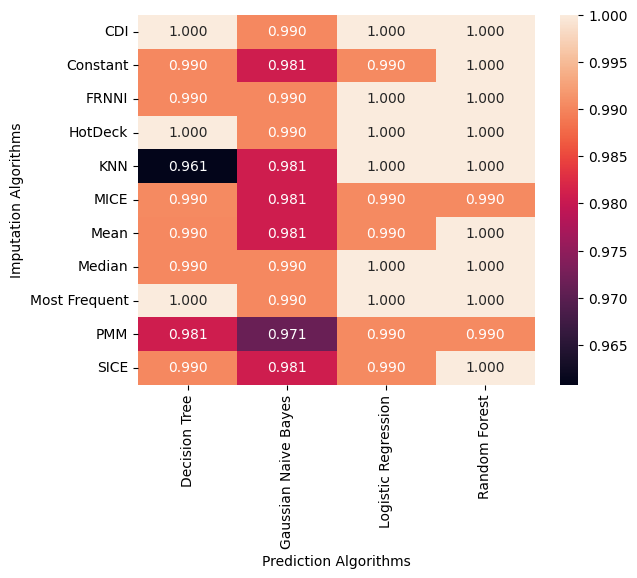

In [ ]:
acc_df = pd.DataFrame(acc_data, columns=["Imputation Algorithms", "Prediction Algorithms", "Accuracy"])

accuracy_matrix = acc_df.pivot(
    index="Imputation Algorithms",
    columns="Prediction Algorithms", 
    values="Accuracy"
)

sns.heatmap(accuracy_matrix, annot=True, fmt='.3f')